## Ploting results from feature compression datasets

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle

In [32]:
files_df = {}

for i in os.listdir('embeddings/DMS'):
    s = os.listdir(f'embeddings/DMS/{i}')
    files_df[i] = len(s)

pd.DataFrame.from_dict(files_df, orient='index').reset_index().rename(columns={'index':'Dataset', 0:'#files'}).sort_values('#files')

,Dataset,#files
6,YAP1_HUMAN_Fields2012_singles_esm2_150M,362
36,BRCA1_HUMAN_RING_esm2_150M,660
3,UBE4B_MOUSE_Klevit2013_singles_esm2_150M,899
22,BLAT_ECOLX_Tenaillon2013_esm2_150M,989
28,PABP_YEAST_Fields2013_singles_esm2_150M,1187
17,GAL4_YEAST_Shendure2015_esm2_150M,1195
37,RL401_YEAST_Bolon2013_esm2_150M,1269
8,RL401_YEAST_Fraser2016_esm2_150M,1324
31,RL401_YEAST_Bolon2014_esm2_150M,1435
18,IF1_ECOLI_esm2_150M,1439


In [7]:
embed = pd.read_pickle('embeddings/HIS7_compressed/HIS7_esm2_150M_mean.pkl')
print(embed.shape)
embed.head()

(496137, 641)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
0,HIS7_YEAST_315835,-0.155543,-0.001378,0.011316,-0.054642,0.081170,0.080891,0.036988,-0.080311,-0.003836,...,-0.031398,-0.115347,-0.402717,0.016079,-0.112223,0.011303,-0.095164,-0.003643,-0.184110,-0.052358
1,HIS7_YEAST_390685,-0.153742,0.008390,0.007661,-0.037736,0.047987,0.084903,0.031307,-0.079463,-0.005297,...,-0.025819,-0.116625,-0.410360,0.014667,-0.105246,0.016425,-0.078078,-0.004254,-0.184573,-0.059033
2,HIS7_YEAST_324209,-0.160240,0.002693,-0.006835,-0.045952,0.066094,0.082156,0.032419,-0.085793,-0.005723,...,-0.023803,-0.109018,-0.399115,-0.002590,-0.121626,0.011350,-0.088656,-0.003923,-0.180800,-0.041902
3,HIS7_YEAST_167759,-0.159427,0.012364,0.016549,-0.050081,0.076912,0.087786,0.022870,-0.090178,0.003722,...,-0.021471,-0.096458,-0.377291,0.034713,-0.110156,0.013263,-0.092327,0.004515,-0.182487,-0.053771
4,HIS7_YEAST_102092,-0.170423,-0.015183,0.022487,-0.067134,0.104415,0.090297,0.035312,-0.080760,-0.003986,...,-0.018363,-0.107169,-0.375497,0.031552,-0.130450,0.004513,-0.102950,0.001648,-0.178366,-0.057600


In [9]:
embed[~embed['Unnamed: 0'].str.contains('HIS7')]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639


In [6]:
embed.to_pickle('embeddings/HIS7_compressed/HIS7_esm2__mean.pkl')

# FULL Pipeline

In [ ]:
# Once we have all the fasta files and metadata we can extract the embeddings for each fasta.
python scripts/extract.py esm2_t30_150M_UR50D data/sumo1_human_data.fasta embeddings/sumo1_esm2_150M --repr_layers 30 --include bos mean per_tok


# Then we can compress the embeddings with the following command
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        pickle.dump(embed, f)


# or one by one, but will take too long
python scripts/compressing_embeddings_v02.py  -e embeddings/sumo1_esm2_150M -c mean -l 30


# or by using the following command, see the script for more details
bash run_compression.sh


# with the compressed embedding we can run the regression model, see script for more details
python scripts/run_reg_Lasso.py -i embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed -m data/BLAT_ECOLX_Ostermeier2014_metadata_v02.csv -o results/BLAT_ECOLX_Ostermeier2014_esm2_150M_layer_30_compressed.csv

In [2]:
def load_embed(base_dir, rep_layer):
    embeddings = {}
    count=0
    total_files = len(os.listdir(base_dir))
    for f in os.listdir(base_dir):
        file = os.path.join(base_dir, f)
        embed = torch.load(file, weights_only=True)
        label = embed['label']
        tensor = embed['mean_representations'][rep_layer].numpy()
        embeddings[label]=tensor
        
        count+=1
        if count % 1000==0:
            print(f"Files processed {count}/{total_files}")

    return embeddings

In [5]:
embed = load_embed('embeddings/DMS9/BLAT_ECOLX_Ranganathan2015_esm2_8M', 6)
embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
embed_df.rename(columns={'index': 'ID'}, inplace=True)
embed_df

,ID,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,BLAT_Ran_L205W,-0.029987,-0.068370,0.338765,0.050486,0.264115,-0.138559,0.156622,0.021205,-0.243745,...,0.136429,0.025811,0.119411,0.205675,-0.075967,-0.324478,-0.198615,0.265854,0.049920,-0.048815
1,BLAT_Ran_E270G,-0.031680,-0.071187,0.338464,0.054233,0.264715,-0.138930,0.158250,0.017811,-0.249605,...,0.133988,0.025203,0.115680,0.202281,-0.076543,-0.323500,-0.200283,0.272884,0.053774,-0.044963
2,BLAT_Ran_L55D,-0.023344,-0.063785,0.338595,0.056440,0.273075,-0.125816,0.155622,0.021127,-0.235613,...,0.129637,0.023011,0.116426,0.197768,-0.076897,-0.337571,-0.196781,0.268533,0.052746,-0.040247
3,BLAT_Ran_R41C,-0.020273,-0.073054,0.332855,0.049391,0.264282,-0.133265,0.159675,0.016805,-0.242094,...,0.138735,0.024156,0.115454,0.199794,-0.078351,-0.321842,-0.198956,0.262061,0.054887,-0.045564
4,BLAT_Ran_K30I,-0.019667,-0.070466,0.333774,0.042534,0.266272,-0.139021,0.160868,0.025497,-0.242057,...,0.140729,0.019821,0.118241,0.201160,-0.066554,-0.325459,-0.193393,0.263727,0.056051,-0.056610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,BLAT_Ran_R159A,-0.021805,-0.064358,0.340071,0.050305,0.269389,-0.130601,0.159941,0.025256,-0.244207,...,0.130043,0.026502,0.116366,0.204330,-0.077716,-0.331424,-0.199756,0.271182,0.051252,-0.048107
4992,BLAT_Ran_V106R,-0.034579,-0.069543,0.337118,0.062721,0.263073,-0.142163,0.156093,0.023191,-0.252553,...,0.138575,0.022313,0.119383,0.200193,-0.077308,-0.331662,-0.193408,0.269234,0.051737,-0.047377
4993,BLAT_Ran_Y44M,-0.023405,-0.061963,0.339548,0.054402,0.266270,-0.138972,0.157281,0.025777,-0.253180,...,0.135817,0.026271,0.120902,0.206557,-0.077008,-0.322505,-0.194319,0.265226,0.054340,-0.046961
4994,BLAT_Ran_R91M,-0.018327,-0.064692,0.338014,0.054126,0.267900,-0.137896,0.159782,0.026262,-0.238965,...,0.128328,0.028663,0.106632,0.206445,-0.073738,-0.337040,-0.202239,0.265517,0.047601,-0.051750


In [ ]:
# # checking corrupted files
# path_compressed_embeds = 'embeddings/DMS9/BLAT_ECOLX_Ranganathan2015_esm2_8M'
# for file in os.listdir(path_compressed_embeds):
#     if file.endswith('.pkl'):
#         method = file.split('_')[-1].split('.')[0]
#         print('\nResults for method:', method)
#         file_path = os.path.join(path_compressed_embeds, file)
#         embed = pd.read_pickle(file_path)
#         embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
#         embed_df.rename(columns={'index': 'ID'}, inplace=True)

In [6]:
meta_data = pd.read_csv('data/metadata_DMS/BLAT_ECOLX_Ranganathan2015_metadata.csv', index_col=0)
meta_data

,ID,mutant,target,sequence
0,BLAT_Ran_H24C,H24C,-0.418260,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Ran_H24E,H24E,-0.279024,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Ran_H24D,H24D,-0.181607,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Ran_H24G,H24G,-0.060242,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Ran_H24F,H24F,-0.818487,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...
...,...,...,...,...
4991,BLAT_Ran_W286S,W286S,-2.967712,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4992,BLAT_Ran_W286R,W286R,-2.707731,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4993,BLAT_Ran_W286T,W286T,-2.806422,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4994,BLAT_Ran_W286V,W286V,-2.813837,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


## Results

In [2]:
def plot_results(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()

In [4]:
def plot_results2(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='rho_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('rho Score')
    plt.xlabel('Compression methd')
    plt.show()

## Results DMS

In [19]:
data = pd.read_csv('/stor/work/Wilke/luiz/DMS_iDCT/results/summary_DMS_150M_lassoCV.csv')

data = data.query("Compression_methd == 'mean'").copy()
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
30,CALM1 HUMAN,Lasso,1,0.088342,0.269512,0.339358,0.053012,0.280916,0.355330,0.283209,0.227340,34,mean
31,CALM1 HUMAN,Lasso,2,0.093685,0.261467,0.331649,0.035367,0.300913,0.382278,0.298341,0.199859,33,mean
32,CALM1 HUMAN,Lasso,3,0.096740,0.272773,0.343829,0.013593,0.271419,0.335491,0.294732,0.146841,37,mean
33,CALM1 HUMAN,Lasso,4,0.109630,0.271159,0.341656,0.010183,0.265148,0.335314,0.316824,0.148861,43,mean
34,CALM1 HUMAN,Lasso,5,0.074047,0.274657,0.345345,0.079287,0.261989,0.336908,0.268399,0.281219,29,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,BG505 env,Lasso,1,0.195423,1.690128,1.997809,0.193891,1.676652,1.988286,0.438204,0.425944,48,mean
2761,BG505 env,Lasso,2,0.265533,1.600250,1.908926,0.243156,1.614411,1.924897,0.510933,0.489611,106,mean
2762,BG505 env,Lasso,3,0.200257,1.684886,1.992114,0.168541,1.696273,2.018000,0.443502,0.398482,44,mean
2763,BG505 env,Lasso,4,0.197833,1.680547,1.991473,0.190019,1.700746,2.005311,0.437501,0.429422,45,mean


In [20]:
cols = ['Dataset', 'R2_score_test', 'rho_score_test']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('rho_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
2374,PABP doubles,Lasso,5,0.758130,0.150031,0.192816,0.749241,0.152444,0.195076,0.899111,0.892414,471,mean
2370,PABP doubles,Lasso,1,0.758891,0.149933,0.192376,0.745393,0.152281,0.197139,0.899615,0.892320,475,mean
2371,PABP doubles,Lasso,2,0.758003,0.149781,0.192388,0.749449,0.153128,0.196894,0.899582,0.892236,468,mean
2372,PABP doubles,Lasso,3,0.756899,0.150443,0.192600,0.753207,0.150812,0.196356,0.898668,0.899595,469,mean
2373,PABP doubles,Lasso,4,0.758308,0.149768,0.192841,0.748281,0.153501,0.195036,0.898028,0.898834,483,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,CALM1 HUMAN,Lasso,2,0.093685,0.261467,0.331649,0.035367,0.300913,0.382278,0.298341,0.199859,33,mean
34,CALM1 HUMAN,Lasso,5,0.074047,0.274657,0.345345,0.079287,0.261989,0.336908,0.268399,0.281219,29,mean
33,CALM1 HUMAN,Lasso,4,0.109630,0.271159,0.341656,0.010183,0.265148,0.335314,0.316824,0.148861,43,mean
32,CALM1 HUMAN,Lasso,3,0.096740,0.272773,0.343829,0.013593,0.271419,0.335491,0.294732,0.146841,37,mean


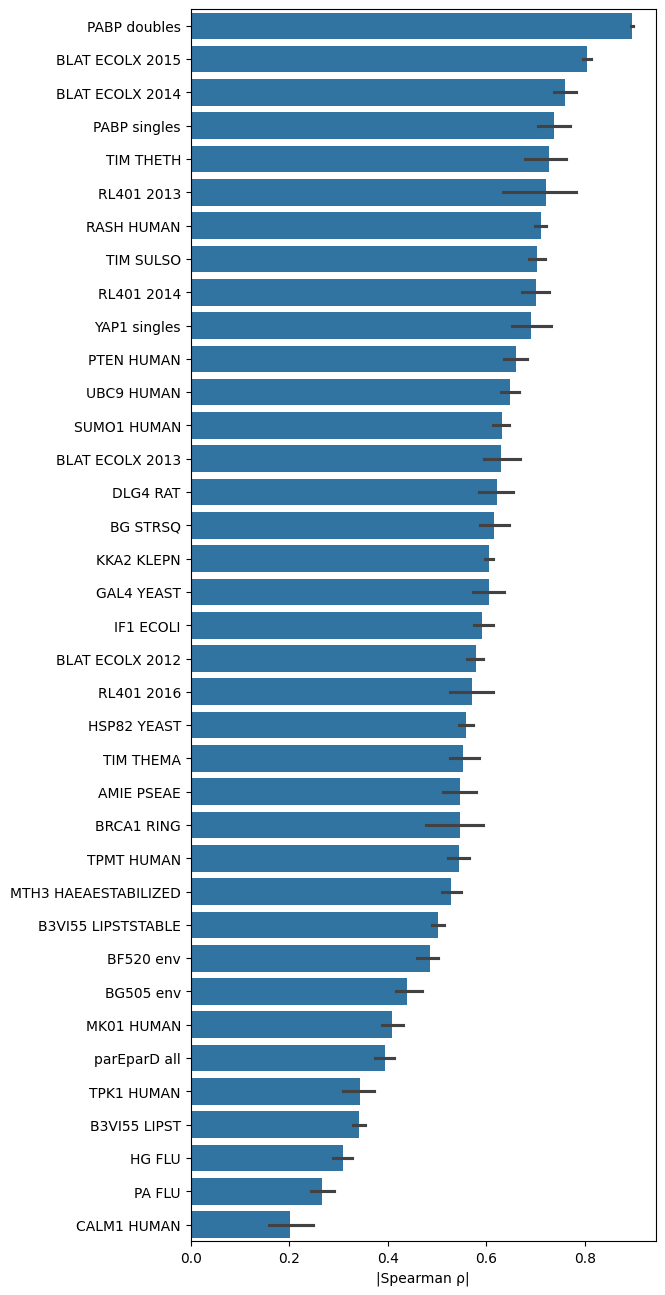

In [23]:
plt.figure(figsize=(6, 16))
sns.barplot(data=data, y='Dataset', x='rho_score_test')
plt.ylabel('rho_score_test')
plt.ylabel('')
plt.xlabel('|Spearman ρ|')
plt.savefig('results/summary_DMS_150M_spearman.png', dpi=600, bbox_inches='tight')
plt.show()

In [8]:
del_data = ['POLG_HCVJF_Sun2014', 'BRCA1_HUMAN_BRCT','UBE4B_MOUSE_Klevit2013_singles']
data['Dataset'] = data['Dataset'].astype('object')
data_plot = data[~data['Dataset'].isin(del_data)].copy()
data_plot

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
479,PABP_YEAST_Fields2013_doubles,Lasso,10,0.631293,0.189169,0.238089,0.628551,0.188431,0.235669,0.828631,0.821527,146,maxPool
529,PABP_YEAST_Fields2013_doubles,Lasso,10,0.592134,0.199608,0.250414,0.584717,0.199911,0.249186,0.802102,0.791046,122,rbf1
528,PABP_YEAST_Fields2013_doubles,Lasso,9,0.590827,0.199695,0.250410,0.598496,0.199154,0.248654,0.801069,0.805510,123,rbf1
527,PABP_YEAST_Fields2013_doubles,Lasso,8,0.592399,0.199505,0.250149,0.585803,0.199849,0.250463,0.801240,0.802664,120,rbf1
526,PABP_YEAST_Fields2013_doubles,Lasso,7,0.591408,0.199814,0.250527,0.592822,0.197768,0.247750,0.801271,0.800164,121,rbf1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,CALM1_HUMAN_Roth2017,Lasso,4,0.264532,0.235876,0.303687,0.043707,0.285867,0.375443,0.488420,0.247820,170,maxPool
820,CALM1_HUMAN_Roth2017,Lasso,1,0.195614,0.250256,0.321220,0.061117,0.265632,0.339460,0.422231,0.251132,126,mean
818,CALM1_HUMAN_Roth2017,Lasso,9,0.246735,0.245042,0.311591,0.170108,0.238354,0.311951,0.481654,0.348144,178,sigmoid2
819,CALM1_HUMAN_Roth2017,Lasso,10,0.250865,0.241806,0.309079,0.081197,0.265002,0.344329,0.486776,0.303512,173,sigmoid2


In [4]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI']

name_map = dict(zip(old_names, new_names))
name_map

{'HG_FLU_Bloom2016': 'HG FLU',
 'BLAT_ECOLX_Ostermeier2014': 'BLAT ECOLX 2014',
 'RL401_YEAST_Bolon2014': 'RL401 2014',
 'PABP_YEAST_Fields2013_doubles': 'PABP doubles',
 'B3VI55_LIPST_Whitehead2015': 'B3VI55 LIPST',
 'TIM_THETH': 'TIM THETH',
 'CALM1_HUMAN_Roth2017': 'CALM1 HUMAN',
 'parEparD_Laub2015_all': 'parEparD all',
 'BF520_env_Bloom2018': 'BF520 env',
 'UBC9_HUMAN_Roth2017': 'UBC9 HUMAN',
 'DLG4_RAT_Ranganathan2012': 'DLG4 RAT',
 'BRCA1_HUMAN_RING': 'BRCA1 RING',
 'TPMT_HUMAN_Fowler2018': 'TPMT HUMAN',
 'MTH3_HAEAESTABILIZED_Tawfik2015': 'MTH3 HAEAESTABILIZED',
 'HSP82_YEAST_Bolon2016': 'HSP82 YEAST',
 'MK01_HUMAN_Johannessen': 'MK01 HUMAN',
 'PTEN_HUMAN_Fowler2018': 'PTEN HUMAN',
 'BG505_env_Bloom2018': 'BG505 env',
 'BLAT_ECOLX_Tenaillon2013': 'BLAT ECOLX 2013',
 'TIM_SULSO': 'TIM SULSO',
 'B3VI55_LIPSTSTABLE': 'B3VI55 LIPSTSTABLE',
 'RL401_YEAST_Bolon2013': 'RL401 2013',
 'PABP_YEAST_Fields2013_singles': 'PABP singles',
 'BLAT_ECOLX_Ranganathan2015': 'BLAT ECOLX 2015',
 'RL

In [11]:
dta = data_plot.drop('Model', axis=1).groupby(['Dataset', 'Compression_methd']).mean()
dta.reset_index(inplace=True)
dta.reset_index(inplace=True, drop=True)
dta

,Dataset,Compression_methd,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs
0,AMIE PSEAE,bos,5.5,0.223505,0.264636,0.334178,0.205185,0.267630,0.337704,0.493429,0.475600,57.9
1,AMIE PSEAE,iDCT,5.5,0.464497,0.212590,0.277517,0.403208,0.223169,0.292659,0.731663,0.687478,246.6
2,AMIE PSEAE,maxPool,5.5,0.380658,0.231302,0.298452,0.340511,0.237712,0.307668,0.650134,0.622094,140.2
3,AMIE PSEAE,mean,5.5,0.320527,0.239761,0.312605,0.291992,0.244672,0.318741,0.578010,0.553673,90.7
4,AMIE PSEAE,pca1,5.5,0.349872,0.239549,0.305779,0.307889,0.246401,0.315135,0.623296,0.589364,144.2
...,...,...,...,...,...,...,...,...,...,...,...,...
365,parEparD all,pca2,5.5,0.592681,0.047857,0.089921,0.582222,0.048262,0.090524,0.470023,0.467937,56.5
366,parEparD all,rbf1,5.5,0.646680,0.043030,0.083747,0.633425,0.043527,0.084737,0.458012,0.455400,78.7
367,parEparD all,rbf2,5.5,0.504987,0.051695,0.099129,0.496193,0.051956,0.099501,0.459301,0.458865,39.8
368,parEparD all,sigmoid1,5.5,0.646152,0.043094,0.083809,0.632742,0.043606,0.084811,0.459335,0.456679,77.4


# Multi Model Results on DMS9 dataset

In [11]:
cols_order = [
    'Dataset', 'Compression_method', 'Model', 'Fold', 'nun_zero_coefs', 
    'R2_score_train', 'MAE_score_train', 'RMSE_score_train', 'rho_score_train', 
    'R2_score_test', 'MAE_score_test', 'RMSE_score_test', 'rho_score_test',
    ]

In [12]:
df = pd.DataFrame()
for file in os.listdir('results/lassoCV_DMS9/'):
    if file.endswith('.csv'):
        target = file.split('_esm2_')[0]
        model = file.split('_esm2_')[1].split('_')[0]
        data = pd.read_csv(f'results/lassoCV_DMS9/{file}', index_col=0)
        data['Model'] = model
        data['Dataset'] = target
        df = pd.concat([df, data])

df= df[cols_order].copy() 
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,RL401_YEAST_Bolon2014,mean,150M,1,83,0.604357,0.185047,0.258908,0.722045,0.571506,0.184628,0.249809,0.730874
1,RL401_YEAST_Bolon2014,mean,150M,2,190,0.775075,0.139150,0.194242,0.773434,0.608409,0.159835,0.243687,0.661513
2,RL401_YEAST_Bolon2014,mean,150M,3,88,0.625654,0.177377,0.249001,0.729980,0.524448,0.204937,0.276760,0.689689
3,RL401_YEAST_Bolon2014,mean,150M,4,85,0.611937,0.178466,0.248488,0.730821,0.535165,0.208633,0.294808,0.675884
4,RL401_YEAST_Bolon2014,mean,150M,5,79,0.579664,0.187125,0.260591,0.714691,0.582016,0.200389,0.271566,0.741424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TIM_THETH,mean,650M,1,35,0.361872,0.407207,0.478669,0.615656,0.356228,0.433639,0.505136,0.608920
1,TIM_THETH,mean,650M,2,30,0.374910,0.410856,0.480435,0.626150,0.343961,0.409030,0.484298,0.600788
2,TIM_THETH,mean,650M,3,29,0.392636,0.403539,0.476080,0.645237,0.245562,0.430768,0.507148,0.445796
3,TIM_THETH,mean,650M,4,29,0.349340,0.420637,0.491391,0.604669,0.353172,0.409031,0.477512,0.625267


In [13]:
#df.to_csv('results/summary_results/summary_lassoCV_multi_model_DMS9.csv')

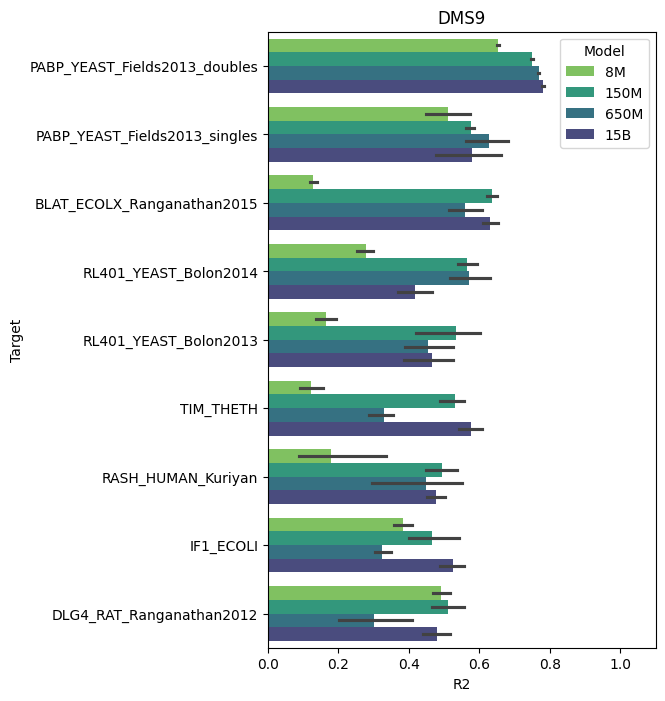

In [14]:
# Datasets order
mean_scores = df.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)
sorted_datasets = mean_scores.index

# plot
plt.figure(figsize=(5, 8))
plt.title('DMS9')
sns.barplot(data=df, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets, hue_order=[ '8M', '150M', '650M', '15B'], palette='viridis_r')
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

plt.savefig('results/summary_results/summary_lassoCV_multi_model_DMS9.png', dpi=600, bbox_inches='tight')
plt.show()

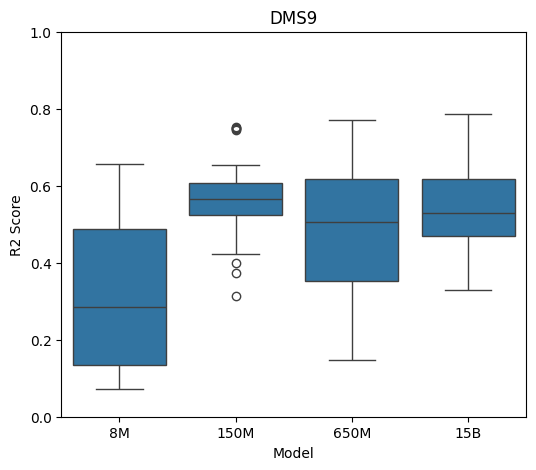

In [43]:
plt.figure(figsize=(6, 5))
plt.title('DMS9')
sns.boxplot(data=df, x='Model', y='R2_score_test', order=[ '8M', '150M', '650M', '15B'])
plt.ylabel('R2 Score')
plt.ylim(0, 1)
plt.show()

# Multi Model Results on Pisces dataset

In [15]:
df = pd.DataFrame()
for file in os.listdir('results/lassoCV_pisces/'):
    if file.endswith('.csv'):
        target = file.split('_esm2_')[0]
        model = file.split('_esm2_')[1].split('_')[0]
        data = pd.read_csv(f'results/lassoCV_pisces/{file}', index_col=0)
        data['Model'] = model
        data['Dataset'] = target
        df = pd.concat([df, data])

df= df[cols_order].copy() 
df      

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,PCP_Isoelectric_point,mean,8M,1,287,0.799460,0.595982,0.767367,0.910691,0.791005,0.602521,0.779134,0.907771
1,PCP_Isoelectric_point,mean,8M,2,288,0.799838,0.593878,0.764184,0.912329,0.790958,0.607289,0.789296,0.908557
2,PCP_Isoelectric_point,mean,8M,3,294,0.799176,0.595772,0.767554,0.910368,0.793497,0.604156,0.775867,0.913349
3,PCP_Isoelectric_point,mean,8M,4,297,0.800730,0.593010,0.762937,0.913067,0.787173,0.610467,0.794471,0.904662
4,PCP_Isoelectric_point,mean,8M,5,288,0.798719,0.597030,0.769494,0.911488,0.793721,0.602982,0.770994,0.905270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,PCP_AAfreq_Ala,mean,150M,1,515,0.971307,0.004707,0.006120,0.983775,0.969310,0.004859,0.006320,0.982635
1,PCP_AAfreq_Ala,mean,150M,2,512,0.971735,0.004676,0.006071,0.983935,0.967161,0.005058,0.006551,0.981422
2,PCP_AAfreq_Ala,mean,150M,3,508,0.971172,0.004730,0.006138,0.983793,0.970473,0.004732,0.006183,0.982911
3,PCP_AAfreq_Ala,mean,150M,4,507,0.971237,0.004725,0.006129,0.983568,0.970095,0.004759,0.006230,0.983736


In [20]:
#df.to_csv('results/summary_results/summary_lassoCV_multi_model_pisces.csv')

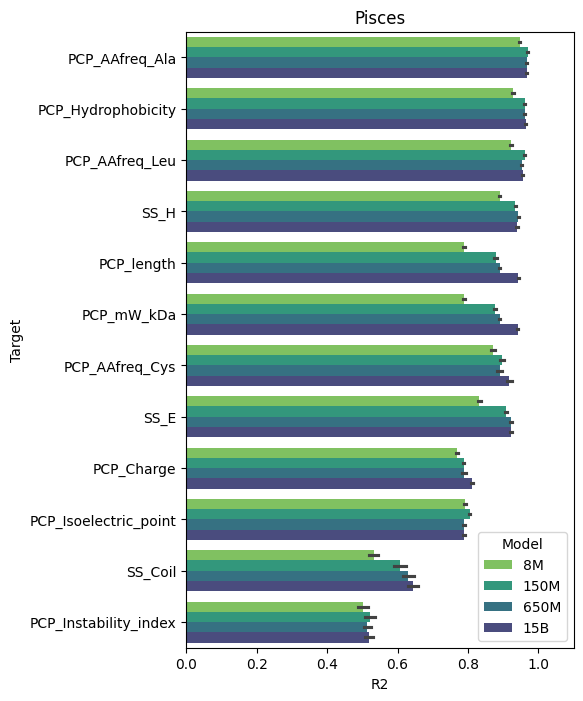

In [16]:
# Datasets order
mean_scores = df.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)
sorted_datasets = mean_scores.index

# plot
plt.figure(figsize=(5, 8))
plt.title('Pisces')
sns.barplot(data=df, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets, hue_order=[ '8M', '150M', '650M', '15B'], palette='viridis_r')
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

plt.savefig('results/summary_results/summary_lassoCV_multi_model_pisces.png', dpi=600, bbox_inches='tight')
plt.show()

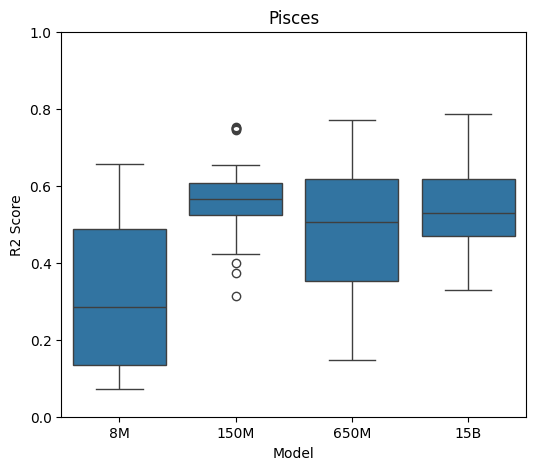

In [42]:
plt.figure(figsize=(6, 5))
plt.title('Pisces')
sns.boxplot(data=df, x='Model', y='R2_score_test', order=[ '8M', '150M', '650M', '15B'])
plt.ylabel('R2 Score')
plt.ylim(0, 1)
plt.show()

## Zero shot predictiond from proteinGym

In [8]:
data = pd.read_csv('results/DMS_zero_shot_ESMs.csv')
data

,DMS ID,ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B)
0,A0A140D2T1_ZIKV_Sourisseau_2019,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375
1,A0A192B1T2_9HIV1_Haddox_2018,0.456,0.492,0.516,-0.003,0.015,0.035,0.080,0.132,0.164
2,A0A1I9GEU1_NEIME_Kennouche_2019,0.040,0.068,0.068,-0.037,-0.047,-0.016,0.030,0.027,0.025
3,A0A247D711_LISMN_Stadelmann_2021,0.087,0.088,0.093,0.064,0.084,0.097,0.066,0.084,0.084
4,A0A2Z5U3Z0_9INFA_Doud_2016,0.124,0.516,0.550,-0.004,0.013,0.064,0.507,0.498,0.501
...,...,...,...,...,...,...,...,...,...,...
212,VKOR1_HUMAN_Chiasson_2020_activity,0.419,0.427,0.448,0.016,0.298,0.369,0.430,0.446,0.445
213,VRPI_BPT7_Tsuboyama_2023_2WNM,0.498,0.368,0.374,0.252,0.410,0.507,0.587,0.612,0.468
214,YAIA_ECOLI_Tsuboyama_2023_2KVT,0.593,0.270,0.481,-0.107,0.173,0.572,0.625,0.684,0.684
215,YAP1_HUMAN_Araya_2012,0.333,0.280,0.285,0.411,0.457,0.451,0.466,0.382,0.313


In [13]:
data = pd.read_csv('results/DMS_zero_shot_ESMs.csv')

val_vars = data.columns.values

data_melted = data.melt(id_vars=['DMS ID'], value_vars=val_vars, var_name='Model', value_name='Rho')
data_melted

,DMS ID,Model,Rho
0,A0A140D2T1_ZIKV_Sourisseau_2019,ESM-1b,-0.001
1,A0A192B1T2_9HIV1_Haddox_2018,ESM-1b,0.456
2,A0A1I9GEU1_NEIME_Kennouche_2019,ESM-1b,0.040
3,A0A247D711_LISMN_Stadelmann_2021,ESM-1b,0.087
4,A0A2Z5U3Z0_9INFA_Doud_2016,ESM-1b,0.124
...,...,...,...
1948,VKOR1_HUMAN_Chiasson_2020_activity,ESM2 (15B),0.445
1949,VRPI_BPT7_Tsuboyama_2023_2WNM,ESM2 (15B),0.468
1950,YAIA_ECOLI_Tsuboyama_2023_2KVT,ESM2 (15B),0.684
1951,YAP1_HUMAN_Araya_2012,ESM2 (15B),0.313


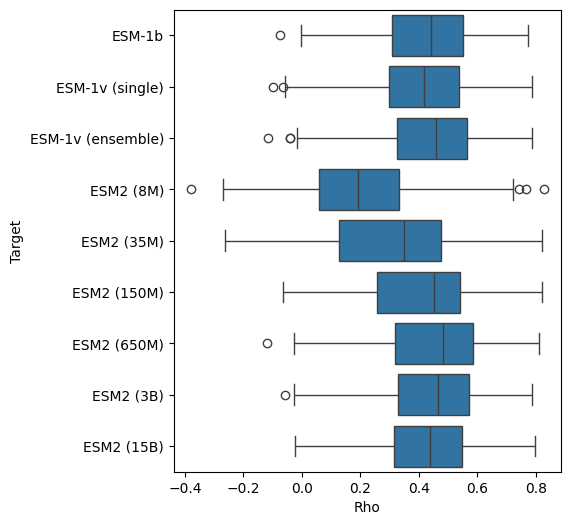

In [14]:
# Plot the boxplot with sorted Model
plt.figure(figsize=(5, 6))
sns.boxplot(data=data_melted, x='Rho', y='Model')
plt.xlabel('Rho')
#plt.xlim(0, 1.1)
plt.ylabel('Target')
plt.show()

# Sample size effect on predictions

## DMS HIS7

In [18]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_{model}_mean.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,0.619895,0.228129,0.263205,-0.601619,0.469460,0.587375,0.784650,0.078811,9,32
1,150M,2,0.000000,0.430087,0.449912,-0.045965,0.418240,0.437628,NaN,NaN,0,32
2,150M,3,0.000000,0.430749,0.452345,-0.000844,0.383574,0.421980,NaN,NaN,0,32
3,150M,4,0.000000,0.427461,0.444831,-0.204463,0.448542,0.462672,NaN,NaN,0,32
4,150M,5,0.999899,0.003331,0.004561,-4.403216,0.808285,0.963538,0.977876,-0.724714,556,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,0.785086,0.155596,0.208231,0.784361,0.155505,0.208202,0.829845,0.827319,1060,496137
1,15B,2,0.785620,0.155481,0.207997,0.782953,0.155795,0.208778,0.829999,0.827626,1024,496137
2,15B,3,0.785580,0.155334,0.207854,0.782883,0.156590,0.209468,0.828984,0.831124,1026,496137
3,15B,4,0.785269,0.155381,0.207996,0.785261,0.155786,0.208356,0.829419,0.829770,1042,496137


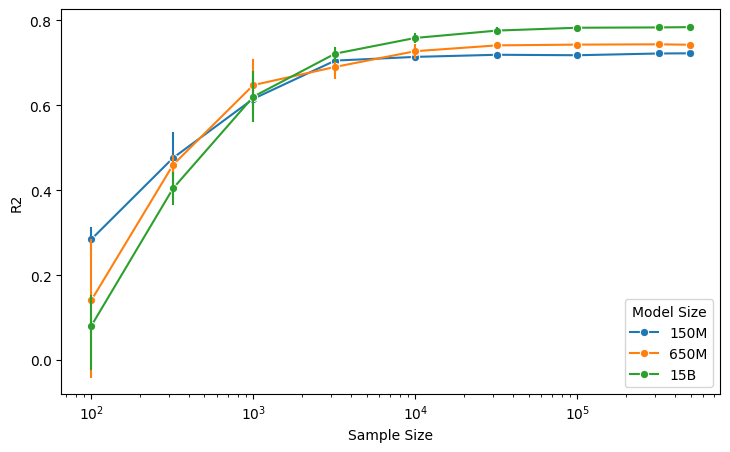

In [19]:
#plotting the results
data = data.query('Sample_size >=100')
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars")
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_R2.png', dpi=600, bbox_inches='tight')
plt.show()

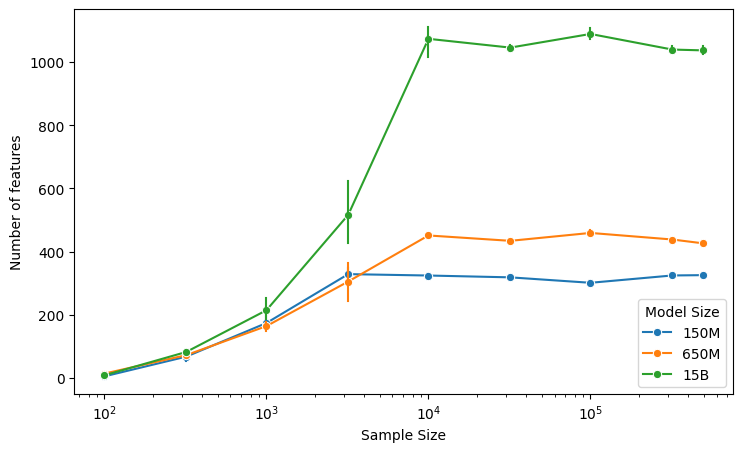

In [20]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars")
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_num_feature.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#data.to_csv('results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_all.csv')

# Sample size contribuition

In [21]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI',
       'UBE4B_MOUSE_Klevit2013_singles', 'HIS7_YEAST_Kondrashov2017', 'POLG_HCVJF_Sun2014', 'BRCA1_HUMAN_BRCT']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI',
       'UBE4B MOUSE', 'HIS7 YEAST', 'POLG HCVJF', 'BRCA1 HUMAN']



name_map = dict(zip(old_names, new_names))

In [22]:
res = pd.read_csv(f'results/summary_results/summary_lassoCV_multi_model_DMS9.csv', index_col=0)
res['Dataset'] = res['Dataset'].map(name_map)
res

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,RL401 2014,mean,150M,1,83,0.604357,0.185047,0.258908,0.722045,0.571506,0.184628,0.249809,0.730874
1,RL401 2014,mean,150M,2,190,0.775075,0.139150,0.194242,0.773434,0.608409,0.159835,0.243687,0.661513
2,RL401 2014,mean,150M,3,88,0.625654,0.177377,0.249001,0.729980,0.524448,0.204937,0.276760,0.689689
3,RL401 2014,mean,150M,4,85,0.611937,0.178466,0.248488,0.730821,0.535165,0.208633,0.294808,0.675884
4,RL401 2014,mean,150M,5,79,0.579664,0.187125,0.260591,0.714691,0.582016,0.200389,0.271566,0.741424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TIM THETH,mean,650M,1,35,0.361872,0.407207,0.478669,0.615656,0.356228,0.433639,0.505136,0.608920
1,TIM THETH,mean,650M,2,30,0.374910,0.410856,0.480435,0.626150,0.343961,0.409030,0.484298,0.600788
2,TIM THETH,mean,650M,3,29,0.392636,0.403539,0.476080,0.645237,0.245562,0.430768,0.507148,0.445796
3,TIM THETH,mean,650M,4,29,0.349340,0.420637,0.491391,0.604669,0.353172,0.409031,0.477512,0.625267


In [23]:
dict_len = {}
dir = 'embeddings/DMS/'
for file in os.listdir(dir):
    if file.endswith('_esm2_150M'):
        file_name = file.split('_esm2_150M')[0]
        l = len(os.listdir(f'{dir}/{file}'))
        dict_len[name_map[file_name]] = l

df = pd.DataFrame.from_dict(dict_len, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)
df

,Dataset,length
0,YAP1 singles,362
1,BRCA1 RING,660
2,UBE4B MOUSE,899
3,BLAT ECOLX 2013,989
4,PABP singles,1187
5,GAL4 YEAST,1195
6,RL401 2013,1269
7,RL401 2016,1324
8,RL401 2014,1435
9,IF1 ECOLI,1439


In [24]:
res['dataset_size'] = res.apply(lambda row: dict_len[row['Dataset']], axis=1)
res

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test,dataset_size
0,RL401 2014,mean,150M,1,83,0.604357,0.185047,0.258908,0.722045,0.571506,0.184628,0.249809,0.730874,1435
1,RL401 2014,mean,150M,2,190,0.775075,0.139150,0.194242,0.773434,0.608409,0.159835,0.243687,0.661513,1435
2,RL401 2014,mean,150M,3,88,0.625654,0.177377,0.249001,0.729980,0.524448,0.204937,0.276760,0.689689,1435
3,RL401 2014,mean,150M,4,85,0.611937,0.178466,0.248488,0.730821,0.535165,0.208633,0.294808,0.675884,1435
4,RL401 2014,mean,150M,5,79,0.579664,0.187125,0.260591,0.714691,0.582016,0.200389,0.271566,0.741424,1435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TIM THETH,mean,650M,1,35,0.361872,0.407207,0.478669,0.615656,0.356228,0.433639,0.505136,0.608920,1519
1,TIM THETH,mean,650M,2,30,0.374910,0.410856,0.480435,0.626150,0.343961,0.409030,0.484298,0.600788,1519
2,TIM THETH,mean,650M,3,29,0.392636,0.403539,0.476080,0.645237,0.245562,0.430768,0.507148,0.445796,1519
3,TIM THETH,mean,650M,4,29,0.349340,0.420637,0.491391,0.604669,0.353172,0.409031,0.477512,0.625267,1519


In [8]:
print(res.query("Model == '8M'")['R2_score_test'].corr(res.query("Model == '8M'")['dataset_size']))
print(res.query("Model == '150M'")['R2_score_test'].corr(res.query("Model == '150M'")['dataset_size']))
print(res.query("Model == '650M'")['R2_score_test'].corr(res.query("Model == '650M'")['dataset_size']))
print(res.query("Model == '15B'")['R2_score_test'].corr(res.query("Model == '15B'")['dataset_size']))


0.5600726679627362
0.6968601603273428
0.6000501096507697
0.7243736679233299


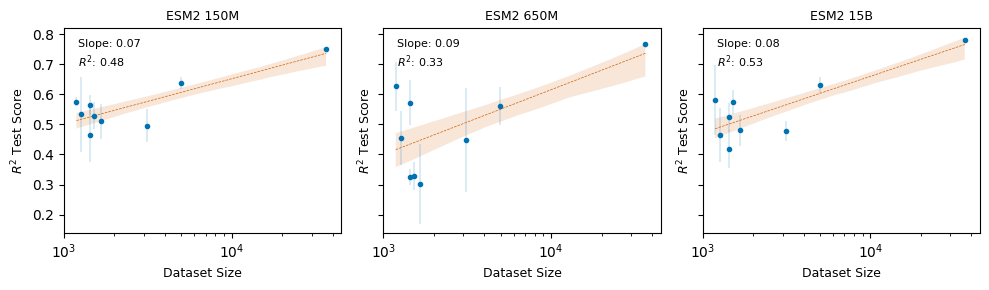

In [99]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for ax, ms in zip(axes, ['150M', '650M', '15B']):
    data = res.query(f"Model == '{ms}'")
    X = np.log(data['dataset_size'].values).reshape(-1, 1)  # Log-transform the x-values, and reshape so X is 2D
    y = data['R2_score_test'].values

    # Fit regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict and calculate R²
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    
    ################ Annotation ################
    # Get mean and standard deviation for each dataset size
    grouped_data = data.groupby('dataset_size')['R2_score_test'].agg(['mean', 'std']).reset_index()
    # Add error bars
    ax.errorbar(grouped_data['dataset_size'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=3, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)
    # Regression line
    sns.regplot(data=data, x='dataset_size', y='R2_score_test', scatter=False, logx=True, color='#D55E00', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    # Annotate
    ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.88, f'$R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.set_title(f'ESM2 {ms}', fontsize=9)
    ax.set_xlabel('Dataset Size', fontsize=9)
    ax.set_ylabel(r'$R^2$ Test Score', fontsize=9)
    ax.set_xlim(1000, 45000)
    ax.set_xscale('log')

plt.tight_layout()
#plt.savefig('results/lassoCV_DMS/summary_all_DMS_results_LassoCV_r2_sloop.png', dpi=600, bbox_inches='tight')
plt.show()

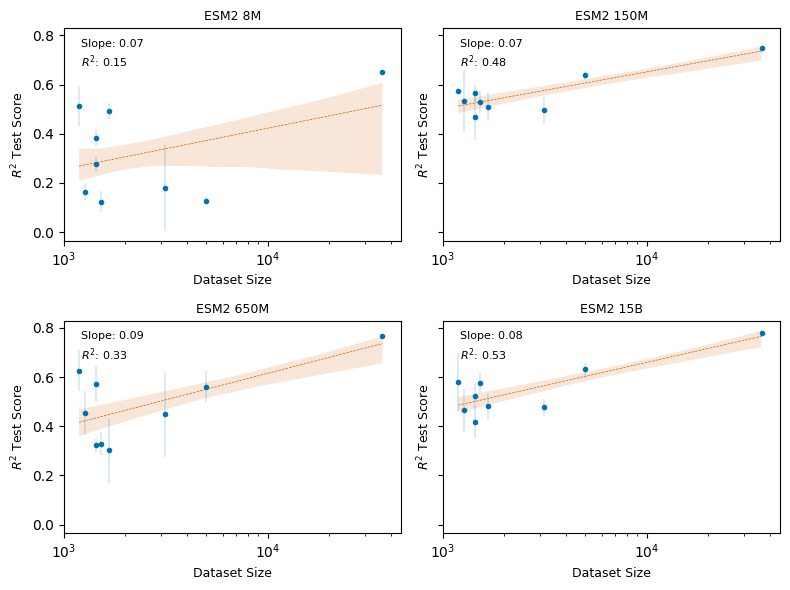

In [25]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

for ax, ms in zip(axes, ['8M', '150M', '650M', '15B']):
    data = res.query(f"Model == '{ms}'")

    X = np.log(data['dataset_size'].values).reshape(-1, 1)  # Log-transform the x-values, and reshape so X is 2D
    y = data['R2_score_test'].values

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict and calculate R²
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    ################ Annotation ################
    # Get mean and standard deviation for each dataset size
    grouped_data = data.groupby('dataset_size')['R2_score_test'].agg(['mean', 'std']).reset_index()
    # Add error bars
    ax.errorbar(grouped_data['dataset_size'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=3, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)
    # Regression line
    sns.regplot(data=data, x='dataset_size', y='R2_score_test', scatter=False, logx=True, color='#D55E00', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    # Annotate
    ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.88, f'$R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.set_title(f'ESM2 {ms}', fontsize=9)
    ax.set_xlabel('Dataset Size', fontsize=9)
    ax.set_ylabel(r'$R^2$ Test Score', fontsize=9)
    ax.set_xlim(1000, 45000)
    ax.set_xscale('log')

plt.tight_layout()
plt.savefig('results/summary_results/summary_all_DMS_results_LassoCV_r2_sloop.png', dpi=600, bbox_inches='tight')
plt.show()